# 2D Structure tensor -  a few examples
A few examples of using 2D structure tensor. The examples show different ways of visualizing the orientations, visualizing the distribution of orientations, and how parameter choices influences the orientationa analysis.

First, a couple of helping functions for easier visualizations.

In [1]:
import numpy as np
import skimage.io
import scipy.ndimage
import matplotlib.pyplot as plt
import st2d

def plot_orientations(ax, dim, vec, s = 5):
    """ Helping function for adding orientation-quiver to the plot.
    Arguments: plot axes, image shape, orientation, arrow spacing. 
    """
    vx = vec[0].reshape(dim)
    vy = vec[1].reshape(dim)
    xmesh, ymesh = np.meshgrid(np.arange(dim[0]), np.arange(dim[1]), indexing='ij')
    ax.quiver(ymesh[s//2::s,s//2::s],xmesh[s//2::s,s//2::s],
              vy[s//2::s,s//2::s],vx[s//2::s,s//2::s],color='r',angles='xy')
    ax.quiver(ymesh[s//2::s,s//2::s],xmesh[s//2::s,s//2::s],
              -vy[s//2::s,s//2::s],-vx[s//2::s,s//2::s],color='r',angles='xy')
    
def polar_histogram(ax, distribution, cmap = 'hsv'):
        """ Helping function for producing polar histogram.
        Arguments: plot axes, oriantation distribution, colormap.
        """
        N = distribution.size
        bin_centers_full = (np.arange(2*N)+0.5)*np.pi/N # full circle (360 deg)
        distribution_full = np.r_[distribution,distribution]/max(distribution) # full normalized distribution
        x = np.r_[distribution_full*np.cos(bin_centers_full),0]
        y = np.r_[distribution_full*np.sin(bin_centers_full),0]
        indices = np.arange(2*N)
        triangles = np.c_[indices, np.roll(indices,1), np.full((2*N,1),2*N)] # triangles[0] is symmetric over 0 degree
        triangle_centers_full = (np.arange(2*N))*np.pi/N # a triangle covers area BETWEEN two bin_centers
        triangle_colors = np.mod(triangle_centers_full, np.pi)/np.pi # from 0 to 1-(1/2N)
        ax.tripcolor(y, x, triangles, facecolors=triangle_colors, cmap=cmap, vmin = 0.0, vmax = 1.0)
        ax.set_aspect('equal')
        ax.set_xlim([-1,1])
        ax.set_ylim([1,-1])        

## Example 1
Orientations computed from simple testing image, and visualized using orientation arrows or color. 

When visualizing predominant orientation information as color without the overlay of intensity image, it may seem as orientation changes abruptly in some areas. However while dominant orientation changes, the anisotropy is low in these areas. This means that transition from one orientation (ellipse elonagted in one direction) to another orientation (ellipse elongated in another directrion) is over an isotropy (a circle). Therefore, the full orientation information (dominant orientation and anisotropy) is smoothly changing. 

The image has a shape (50, 50), i.e. 2500 pixels.
Structure tensor information is carried in a (3, 2500) array.
Orientation information is carried in a (2, 2500) array.
Anisotropy information is carried in a (2, 2500) array.


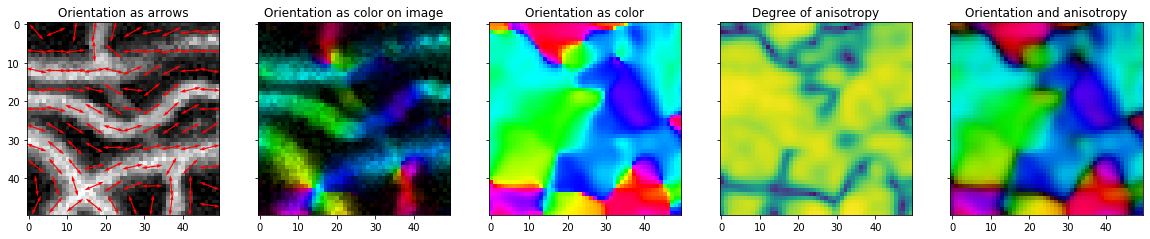

In [8]:
filename = '../data2D/drawn_fibres_B.png';
sigma = 0.5
rho = 2

image = skimage.io.imread(filename)
S = st2d.structure_tensor(image, sigma, rho)
val,vec = st2d.eig_special(S)
print(f'The image has a shape {image.shape}, i.e. {image.size} pixels.')
print(f'Structure tensor information is carried in a {S.shape} array.')
print(f'Orientation information is carried in a {vec.shape} array.')
print(f'Anisotropy information is carried in a {val.shape} array.')

# visualization
figsize = (20,5)
fig, ax = plt.subplots(1, 5, figsize=figsize, sharex=True, sharey=True)
ax[0].imshow(image, cmap=plt.cm.gray)
plot_orientations(ax[0], image.shape, vec)
ax[0].set_title('Orientation as arrows')
orientation_st_rgba = plt.cm.hsv((np.arctan2(vec[1], vec[0])/np.pi).reshape(image.shape))
ax[1].imshow(plt.cm.gray(image)*orientation_st_rgba)
ax[1].set_title('Orientation as color on image')
ax[2].imshow(orientation_st_rgba)
ax[2].set_title('Orientation as color')
anisotropy = (1-val[0]/val[1]).reshape(image.shape)
ax[3].imshow(anisotropy)
ax[3].set_title('Degree of anisotropy')
ax[4].imshow(plt.cm.gray(anisotropy)*orientation_st_rgba)
ax[4].set_title('Orientation and anisotropy')
plt.show()    

## Example 2
Orientation analysis of a slice showing carbord fibres. This example shows how orientation may be collected and shown as a histogram over angles or as a polar histogram. 

Here I collect the orientation information on the whole image. However, as shown above, the orientation information is reliable only in areas of hight anisotropy. For this reason, and depending on problem at hand, it may be desirable to weight the orientation using the anisotropy (remove parts with low anisotropy) or the intensity (remove the background and keep only information of fibres). 

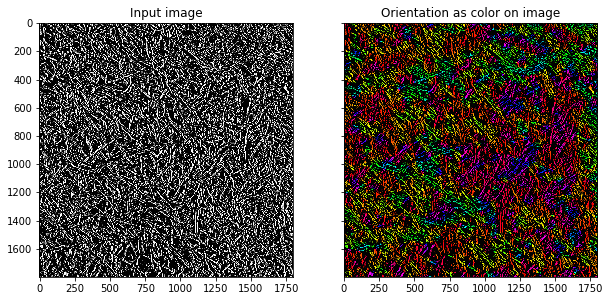

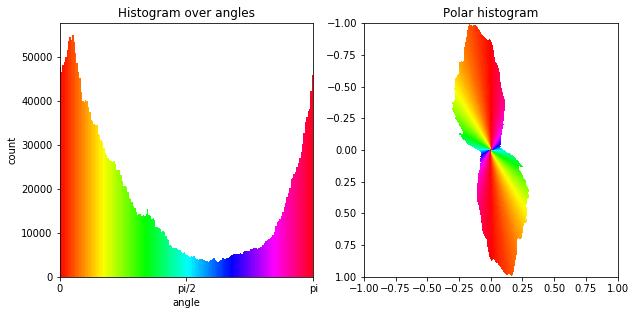

In [3]:
filename = '../data2D/10X.png';
sigma = 0.5
rho = 15
N = 180 # number of angle bins for orientation histogram

# computation
image = skimage.io.imread(filename)
image = np.mean(image[:,:,0:3],axis=2).astype(np.uint8)
S = st2d.structure_tensor(image, sigma, rho)
val,vec = st2d.eig_special(S)
angles = np.arctan2(vec[1], vec[0]) # angles from 0 to pi
distribution = np.histogram(angles, bins=N, range=(0.0, np.pi))[0]

# visualization
figsize = (10,5)
fig, ax = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)
ax[0].imshow(image,cmap=plt.cm.gray)
ax[0].set_title('Input image')
orientation_st_rgba = plt.cm.hsv((angles/np.pi).reshape(image.shape))
ax[1].imshow(plt.cm.gray(image)*orientation_st_rgba)
ax[1].set_title('Orientation as color on image')

fig, ax = plt.subplots(1, 2, figsize=figsize)
bin_centers = (np.arange(N)+0.5)*np.pi/N # halp circle (180 deg)
colors = plt.cm.hsv(bin_centers/np.pi)
ax[0].bar(bin_centers, distribution, width = np.pi/N, color = colors)
ax[0].set_xlabel('angle')
ax[0].set_xlim([0,np.pi])
ax[0].set_aspect(np.pi/ax[0].get_ylim()[1])
ax[0].set_xticks([0,np.pi/2,np.pi])
ax[0].set_xticklabels(['0','pi/2','pi'])
ax[0].set_ylabel('count')
ax[0].set_title('Histogram over angles')
polar_histogram(ax[1], distribution)
ax[1].set_title('Polar histogram')
plt.show()

## OCT example
A example of of computing orientation information from the OCT image of retina.

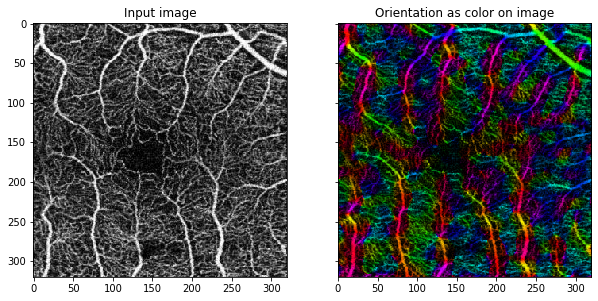

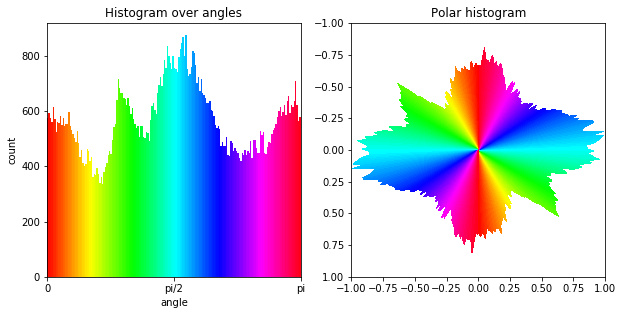

In [4]:
filename = '../data2D/OCT_im_org.png';
sigma = 0.5
rho = 5
N = 180 # number of angle bins for orientation histogram

# computation
image = skimage.io.imread(filename)
S = st2d.structure_tensor(image, sigma, rho)
val,vec = st2d.eig_special(S)
angles = np.arctan2(vec[1], vec[0]) # angles from 0 to pi
distribution = np.histogram(angles, bins=N, range=(0.0, np.pi))[0]

# visualization
figsize = (10,5)
fig, ax = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Input image')
orientation_st_rgba = plt.cm.hsv((angles/np.pi).reshape(image.shape))
ax[1].imshow(plt.cm.gray(image)*orientation_st_rgba)
ax[1].set_title('Orientation as color on image')

fig, ax = plt.subplots(1, 2, figsize=figsize)
bin_centers = (np.arange(N)+0.5)*np.pi/N # halp circle (180 deg)
colors = plt.cm.hsv(bin_centers/np.pi)
ax[0].bar(bin_centers, distribution, width = np.pi/N, color = colors)
ax[0].set_xlabel('angle')
ax[0].set_xlim([0,np.pi])
ax[0].set_aspect(np.pi/ax[0].get_ylim()[1])
ax[0].set_xticks([0,np.pi/2,np.pi])
ax[0].set_xticklabels(['0','pi/2','pi'])
ax[0].set_ylabel('count')
ax[0].set_title('Histogram over angles')
polar_histogram(ax[1], distribution)
ax[1].set_title('Polar histogram')
plt.show()


## Investigating the effect of integration size rho
Integration size rho is a crucial parameter when working with structure tensor, and especially if ofientation information is to be sampled om the image. This example shows how small rho captures the randomness of the individual fibre, and equidistantly placed orientation arrows will appear random. Larger rho captures the orientation on a larger scale, and flow appears smoother. 

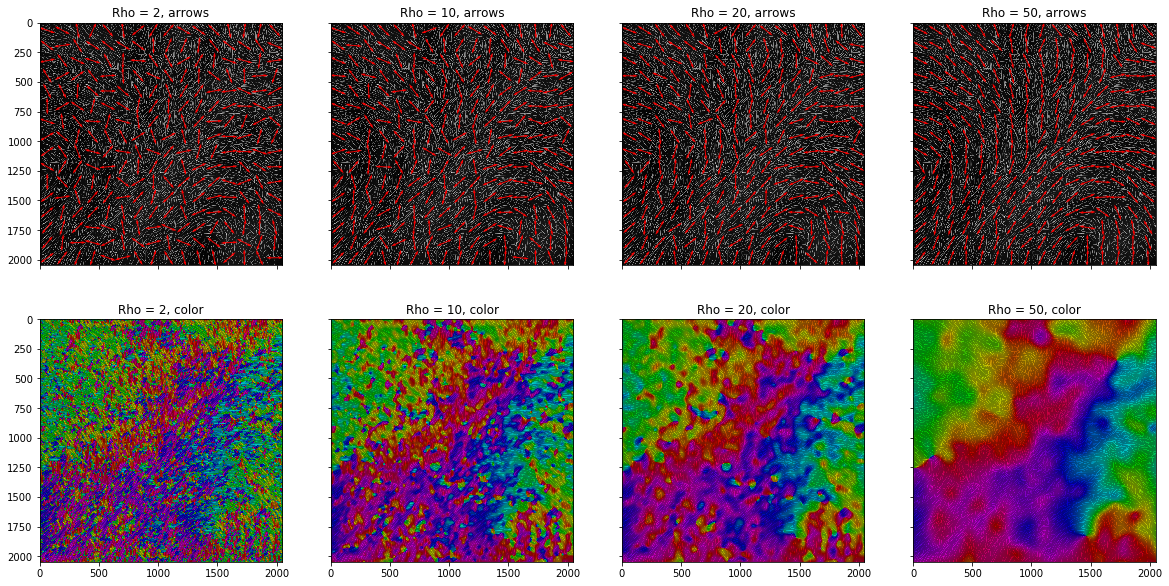

In [5]:
filename = '../data2D/short_fibres.png'
image = skimage.io.imread(filename)
image = np.mean(image[:,:,0:3],axis=2)
image -= np.min(image)
image /= np.max(image)
s = 128 # quiver arrow spacing
sigma = 0.5
figsize = (20,10)

rhos = [2,10,20,50]

fig, ax = plt.subplots(2, len(rhos), figsize=figsize, sharex=True, sharey=True)
for k in range(4):

    # computation
    rho = rhos[k] # changing integration radius
    S = st2d.structure_tensor(image,sigma,rho)
    val,vec = st2d.eig_special(S)

    # visualization
    ax[0][k].imshow(image,cmap=plt.cm.gray)
    plot_orientations(ax[0][k], image.shape, vec, s = s)
    ax[0][k].set_title(f'Rho = {rho}, arrows')
    intensity_rgba = plt.cm.gray(image)
    orientation_st_rgba = plt.cm.hsv((np.arctan2(vec[1], vec[0])/np.pi).reshape(image.shape))
    ax[1][k].imshow((0.5+0.5*intensity_rgba)*orientation_st_rgba)
    ax[1][k].set_title(f'Rho = {rho}, color')

plt.show()

## Investigating the effect of downsampling
This example demonstrates the robustness of structure tensor to downsampling. In highest resolution, individual fibres can be distinguished, and large rho is used to capture a smooth flow. As smaller resolutions, individual fibres cannot be distinguished, but the orientation information, now using a smaller rho, is still rather stable.

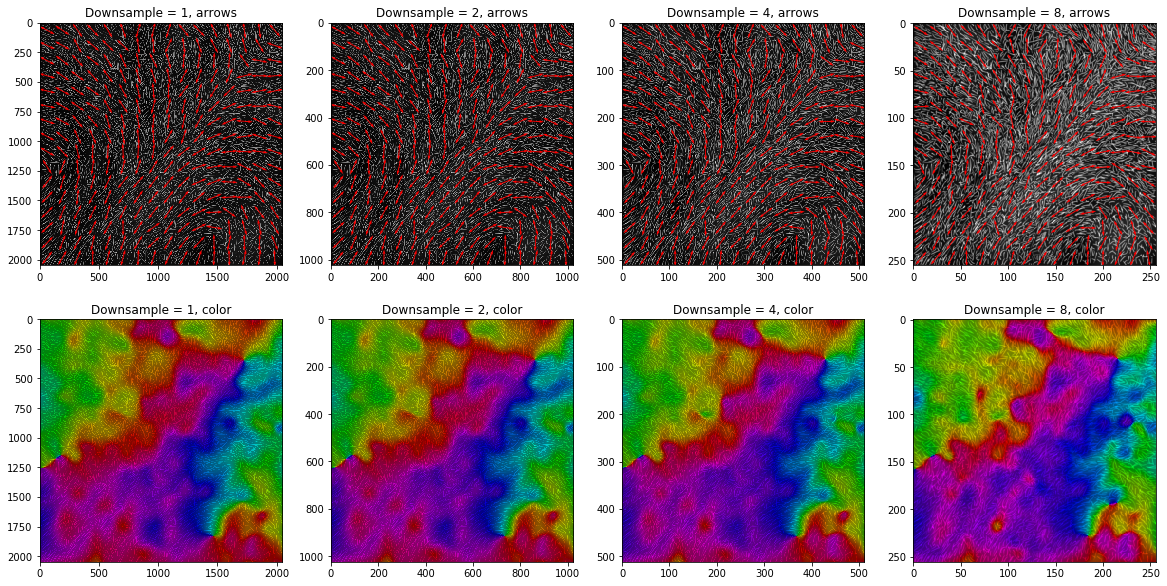

In [6]:
filename = '../data2D/short_fibres.png'
downsampling_range = 4
figsize = (20,10)    
fig, ax = plt.subplots(2, downsampling_range, figsize=figsize)

for k in range(downsampling_range):

    # downsampling and computation
    scale = 2**k
    f = 1/scale # image scale factor
    s = 128//scale # quiver arrow spacing
    sigma = 0.5 # would it make sense to scale this too?
    rho = 50/scale # scaling the integration radius
    image = skimage.io.imread(filename)
    image = np.mean(image[:,:,0:3],axis=2)
    image = skimage.transform.rescale(image,f,multichannel=False)
    image -= np.min(image)
    image /= np.max(image)
    S = st2d.structure_tensor(image,sigma,rho)
    val,vec = st2d.eig_special(S)

    # visualization
    ax[0][k].imshow(image,cmap=plt.cm.gray)
    plot_orientations(ax[0][k], image.shape, vec, s = s)
    ax[0][k].set_title(f'Downsample = {scale}, arrows')
    intensity_rgba = plt.cm.gray(image)
    orientation_st_rgba = plt.cm.hsv((np.arctan2(vec[1], vec[0])/np.pi).reshape(image.shape))
    ax[1][k].imshow((0.5+0.5*intensity_rgba)*orientation_st_rgba)       
    ax[1][k].set_title(f'Downsample = {scale}, color')

plt.show()

## Comparing the dominant orientation with the optical flow
When imaged structures are mostly unidirectional, and we are interested in computing the deviation from this given direction, it may be favorable to compute optical flow. While orientation from structure tensor yields a $(x,y)$ vector per pixel, optical flow in $y$ direction yields a $(x,1)$ vector. However, where assumption on uni-directionality is broken, optical flow is still returning a flow in $y$ direction. 

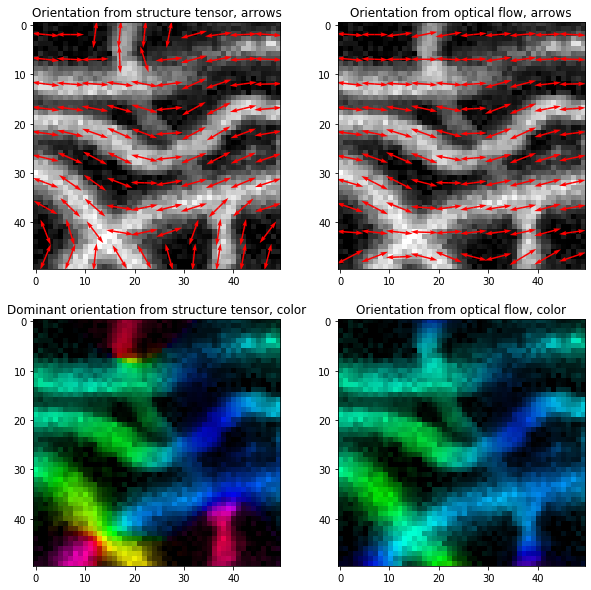

In [7]:
image = skimage.io.imread('../data2D/drawn_fibres_B.png');

# computing structure tensor, orientation and optical flow
sigma = 0.5
rho = 5
S = st2d.structure_tensor(image,sigma,rho)
val,vec = st2d.eig_special(S) # dominant orientation
fx = st2d.solve_flow(S) # optical flow

# visualization
figsize = (10,10)
fy = np.ones(image.shape)
fig, ax = plt.subplots(2,2,figsize=figsize)

ax[0][0].imshow(image,cmap=plt.cm.gray)
plot_orientations(ax[0][0], image.shape, vec)
ax[0][0].set_title('Orientation from structure tensor, arrows')
ax[0][1].imshow(image,cmap=plt.cm.gray)
plot_orientations(ax[0][1], image.shape, np.r_[fx,np.ones((1,image.size))])
ax[0][1].set_title('Orientation from optical flow, arrows')
intensity_rgba = plt.cm.gray(image)
orientation_st_rgba = plt.cm.hsv((np.arctan2(vec[1],vec[0])/np.pi).reshape(image.shape))
orientation_of_rgba = plt.cm.hsv((np.arctan2(1,fx)/np.pi).reshape(image.shape))
ax[1][0].imshow(intensity_rgba*orientation_st_rgba)
ax[1][0].set_title('Dominant orientation from structure tensor, color')
ax[1][1].imshow(intensity_rgba*orientation_of_rgba)
ax[1][1].set_title('Orientation from optical flow, color')
plt.show()